<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation!

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results.

## Install MMSegmentation
This step may take several minutes.

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command.

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install PyTorch
!conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.3 -c pytorch
# Install mim
!pip install -U openmim
# Install mmengine
!mim install mmengine
# Install MMCV
!mim install 'mmcv >= 2.0.0rc1'


/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.2 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 30.3 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 12.9 MB/s eta 0:00:00


In [3]:
!rm -rf mmsegmentation
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 15757, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 15757 (delta 37), reused 92 (delta 21), pack-reused 15625
Receiving objects: 100% (15757/15757), 20.98 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (11061/11061), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

2.0.1+cu118 True
1.1.1


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary.
1. Add a new dataset class.
2. Create a config file accordingly.
3. Perform training and evaluation.

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure.

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization.

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels.
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object.

In [5]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz

--2023-07-30 23:44:43--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘stanford_background.tar.gz’

stanford_background 100%[===================>]  14.04M  4.14MB/s    in 3.9s    

2023-07-30 23:44:47 (3.62 MB/s) - ‘stanford_background.tar.gz’ saved [14727974/14727974]



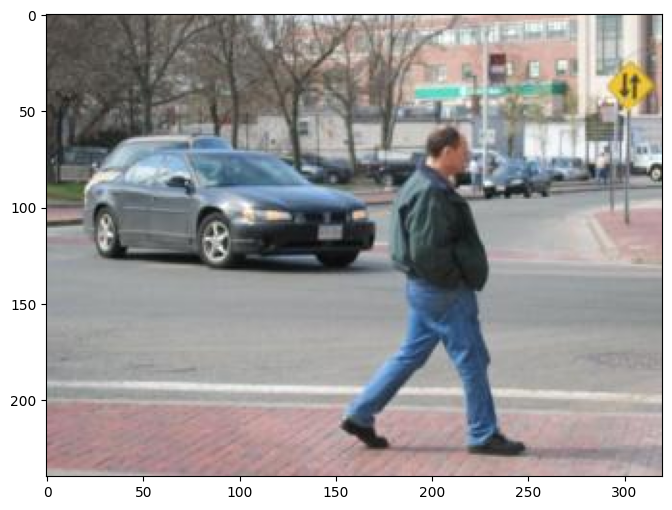

In [6]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [7]:
# define dataset root and directory for images and annotations
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and palette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

In [8]:
import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt',
                                                         '.png')))

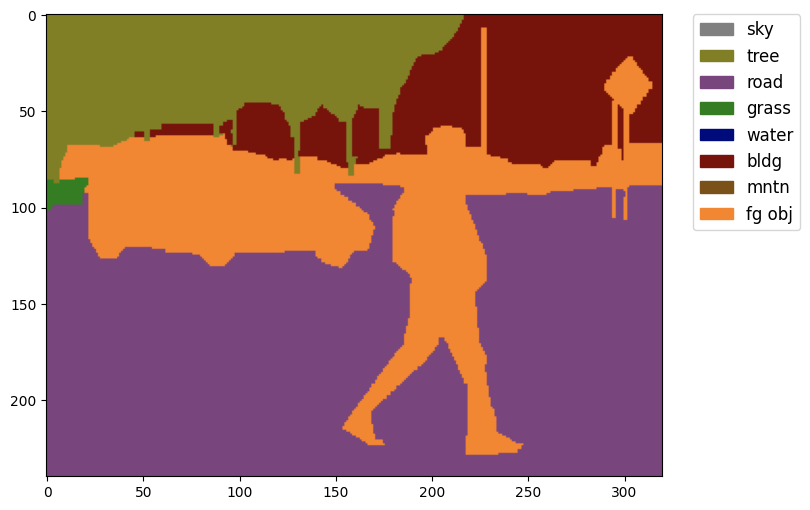

In [9]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

In [10]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [11]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)


### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [12]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 MiB 34.0 MB/s eta 0:00:00
Successfully downloaded pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth to /content/mmsegmentation
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /content/mmsegmentation


In [13]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    std=[
        58.395,
        57.12,
        57.375,
    ],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[
            123.675,
            116.28,
            103.53,
        ],
        std=[
            58.395,
            57.12,
            57.375,
        ],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(
            512,
            1024,
        )),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(
            0,
            1,
            2,
            3,
        ),
        dilations=(
 

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [14]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    std=[
        58.395,
        57.12,
        57.375,
    ],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[
            123.675,
            116.28,
            103.53,
        ],
        std=[
            58.395,
            57.12,
            57.375,
        ],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(
            256,
            256,
        )),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(
            0,
            1,
            2,
            3,
        ),
        dilations=(
      

### Train and Evaluation

In [15]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/30 23:46:03 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=s

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


07/30 23:46:09 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/30 23:46:09 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [16]:
# start training
runner.train()

07/30 23:46:10 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


07/30 23:46:10 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
07/30 23:46:10 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c


Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_v1c-2cccc1ad.pth" to /root/.cache/torch/hub/checkpoints/resnet50_v1c-2cccc1ad.pth


07/30 23:46:15 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
07/30 23:46:16 - mm

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


07/30 23:48:36 - mmengine - INFO - Iter(val) [ 10/143]    eta: 0:01:07  time: 0.5052  data_time: 0.0298  memory: 9163  
07/30 23:48:37 - mmengine - INFO - Iter(val) [ 20/143]    eta: 0:00:40  time: 0.1560  data_time: 0.0023  memory: 9160  
07/30 23:48:39 - mmengine - INFO - Iter(val) [ 30/143]    eta: 0:00:30  time: 0.1521  data_time: 0.0023  memory: 9154  
07/30 23:48:40 - mmengine - INFO - Iter(val) [ 40/143]    eta: 0:00:25  time: 0.1686  data_time: 0.0027  memory: 9162  
07/30 23:48:41 - mmengine - INFO - Iter(val) [ 50/143]    eta: 0:00:19  time: 0.0416  data_time: 0.0025  memory: 4577  
07/30 23:48:41 - mmengine - INFO - Iter(val) [ 60/143]    eta: 0:00:14  time: 0.0420  data_time: 0.0024  memory: 4577  
07/30 23:48:43 - mmengine - INFO - Iter(val) [ 70/143]    eta: 0:00:12  time: 0.1640  data_time: 0.0047  memory: 9158  
07/30 23:48:45 - mmengine - INFO - Iter(val) [ 80/143]    eta: 0:00:10  time: 0.1613  data_time: 0.0049  memory: 9155  
07/30 23:48:45 - mmengine - INFO - Iter(

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

Inference with trained model

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_200.pth
07/30 23:48:52 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


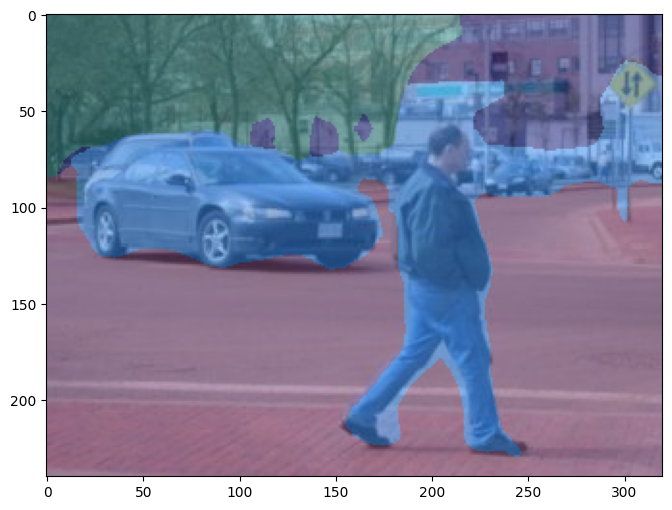

In [17]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('iccv09Data/images/6000124.jpg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
